In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

start_date = '2020-01-01'
end_date = '2023-08-01'

ibm = yf.download('IBM', start = start_date, end = end_date)
ibm

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,129.063095,129.942642,128.843216,129.464630,107.512413,3293436
2020-01-03,127.695984,128.929260,127.686424,128.432129,106.654968,2482890
2020-01-06,127.552582,128.336517,127.342255,128.202682,106.464447,2537073
2020-01-07,127.810707,129.024857,127.533463,128.288712,106.535889,3232977
2020-01-08,128.594650,129.885284,128.030594,129.359467,107.425079,4545916
...,...,...,...,...,...,...
2023-07-25,139.419998,140.429993,139.039993,140.330002,138.733490,3770800
2023-07-26,140.440002,141.250000,139.880005,141.070007,139.465073,4046400
2023-07-27,142.300003,143.380005,141.899994,142.970001,141.343445,6331600


In [2]:
def getBeta(series : pd.DataFrame, sl : int) :
    h1 = series[['High','Low']].values
    h1 = np.log(h1[:,0]/h1[:,1])**2
    h1 = pd.Series(h1, index = series.index)
    beta = h1.rolling(window = 2).sum()
    beta = beta.rolling(window = sl).mean()
    beta = beta.replace([np.inf, -np.inf], np.nan)
    return beta.dropna()

def getGamma(series : pd.DataFrame) :
    h2 = series['High'].rolling(window=2).max()
    l2 = series['Low'].rolling(window=2).min()
    gamma = np.log(h2.values/l2.values)**2
    gamma = pd.Series(gamma, index = h2.index)
    gamma = gamma.replace([np.inf, -np.inf], np.nan)
    return gamma.dropna()

def getAlpha(beta, gamma) :
    alpha = ((np.sqrt(2 * beta) - np.sqrt(beta)) /(3 - (2 * np.sqrt(2)))) - np.sqrt(gamma / (3 - (2 * np.sqrt(2))))
    alpha[alpha<0] = 0
    return alpha.dropna()

def corwinSchultz(series, sl : int = 1) :
    beta = getBeta(series, sl)
    gamma = getGamma(series)
    alpha = getAlpha(beta, gamma)
    spread = 2 * np.exp(alpha - 1)/(1 + np.exp(alpha))
    startTime = pd.Series(series.index[0 : spread.shape[0]], index = spread.index)
    spread = pd.concat([spread,startTime], axis = 1)
    spread.columns = ['Spread', 'Start_time']
    return spread

def getSigma(beta, gamma) :
    k2 = (8/np.pi)**.5
    den = 3-2*2**.5
    sigma = (2**-.5-1)*beta**.5/(k2*den)
    sigma += (gamma/(k2**2*den))**.5
    sigma[sigma<0] = 0
    return sigma

In [3]:
becker_parkinson = getSigma(getBeta(ibm, 1), getGamma(ibm))
becker_parkinson

Date
2020-01-03    0.012715
2020-01-06    0.005449
2020-01-07    0.004895
2020-01-08    0.007860
2020-01-09    0.012788
                ...   
2023-07-25    0.003085
2023-07-26    0.008960
2023-07-27    0.022160
2023-07-28    0.007896
2023-07-31    0.006999
Length: 899, dtype: float64

<Axes: title={'center': 'Becker Parkinson Volatility Estimator'}, xlabel='Date'>

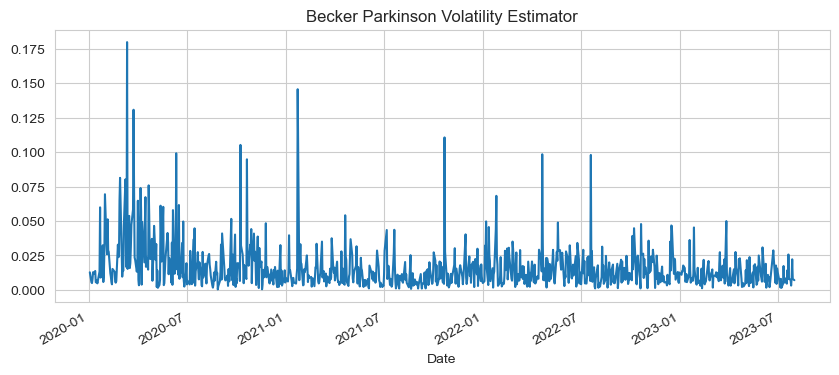

In [4]:
becker_parkinson.plot(figsize = (10,4), title = 'Becker Parkinson Volatility Estimator')

In [5]:
from SpectralAnalysisStateSpaceModel import LocalLinearTrend

model = LocalLinearTrend(becker_parkinson)
result = model.fit(disp = True)

print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64204D-01    |proj g|=  3.56008D+00

At iterate    1    f= -1.55108D+00    |proj g|=  1.12850D+01

At iterate    2    f= -1.60749D+00    |proj g|=  1.15757D+01
  ys=-1.445E-03  -gs= 4.837E-02 BFGS update SKIPPED

At iterate    3    f= -1.60813D+00    |proj g|=  1.15791D+01

At iterate    4    f= -2.25395D+00    |proj g|=  1.80804D+01

At iterate    5    f= -2.51871D+00    |proj g|=  2.93897D+01

At iterate    6    f= -2.67637D+00    |proj g|=  1.11776D+02

At iterate    7    f= -2.69635D+00    |proj g|=  1.59760D+02

At iterate    8    f= -2.70140D+00    |proj g|=  1.20510D+01

At iterate    9    f= -2.70609D+00    |proj g|=  1.94300D+02

At iterate   10    f= -2.70766D+00    |proj g|=  1.18277D+02

At iterate   11    f= -2.70793D+00    |proj g|=  6.41982D+01

At iterate   12    f= -2.70954D+00  

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


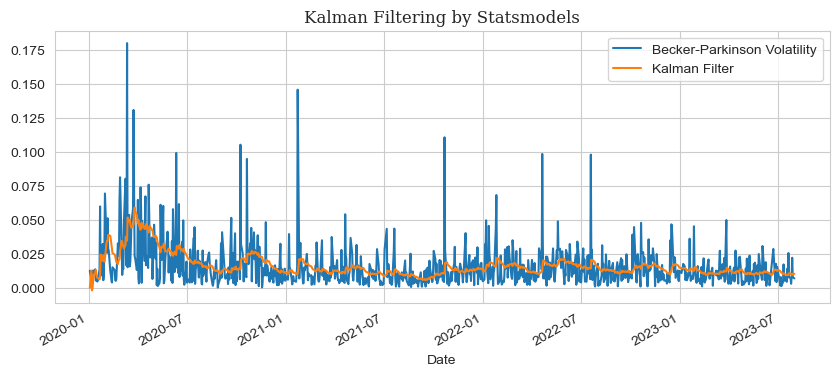

In [6]:
import matplotlib.pyplot as plt
predict = result.get_prediction()
plotting = pd.DataFrame({"Becker-Parkinson Volatility": becker_parkinson,
                      "Kalman Filter": predict.predicted_mean})
plotting.plot(figsize = (10, 4))
plt.title("Kalman Filtering by Statsmodels", fontfamily = 'Serif', fontsize = 12)
plt.show()

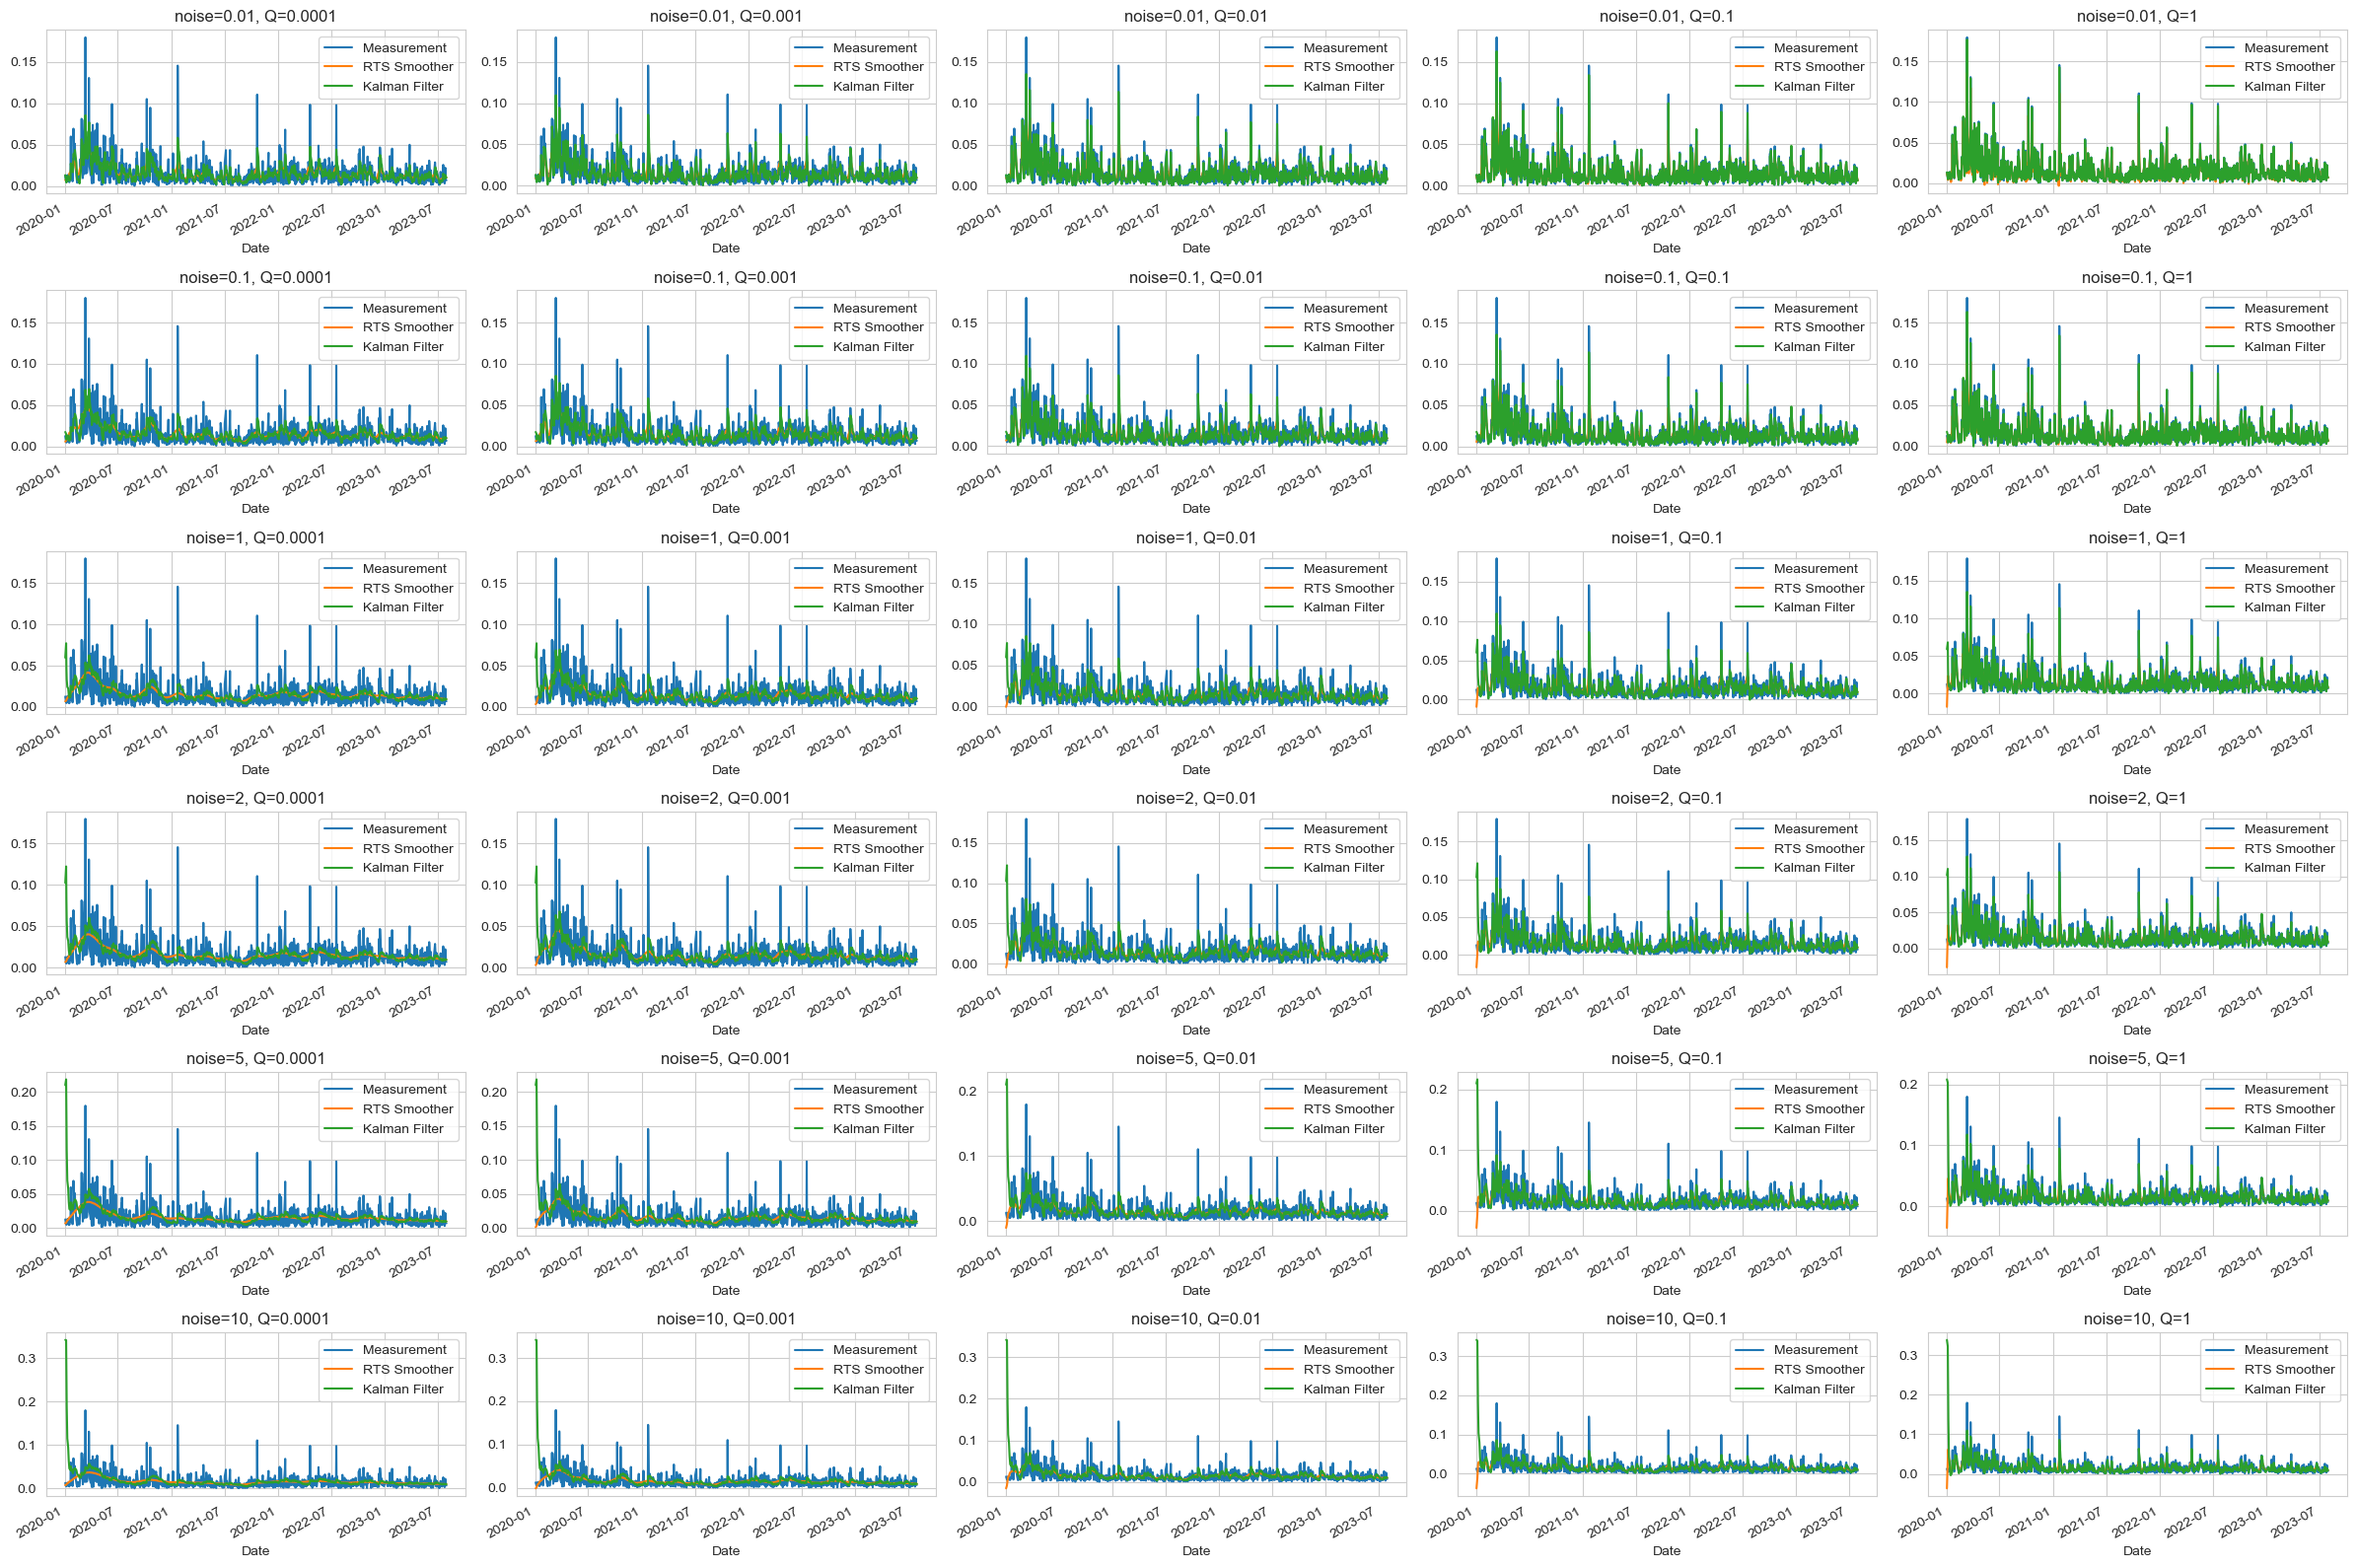

In [7]:
from SpectralAnalysisStateSpaceModel import calculate_fl, calculate_rts

noise = [0.01, 0.1, 1, 2, 5, 10]
Q = [0.0001, 0.001, 0.01, 0.1, 1]

fig, axes = plt.subplots(len(noise), len(Q), figsize=(24, 16))

for x, i in enumerate(noise):
    for y, j in enumerate(Q):
        result = calculate_rts(becker_parkinson, noise=i, Q=j)
        result.plot(ax=axes[x, y], title="noise={}, Q={}".format(i, j))

plt.tight_layout()
plt.show()

<Figure size 2400x1600 with 0 Axes>

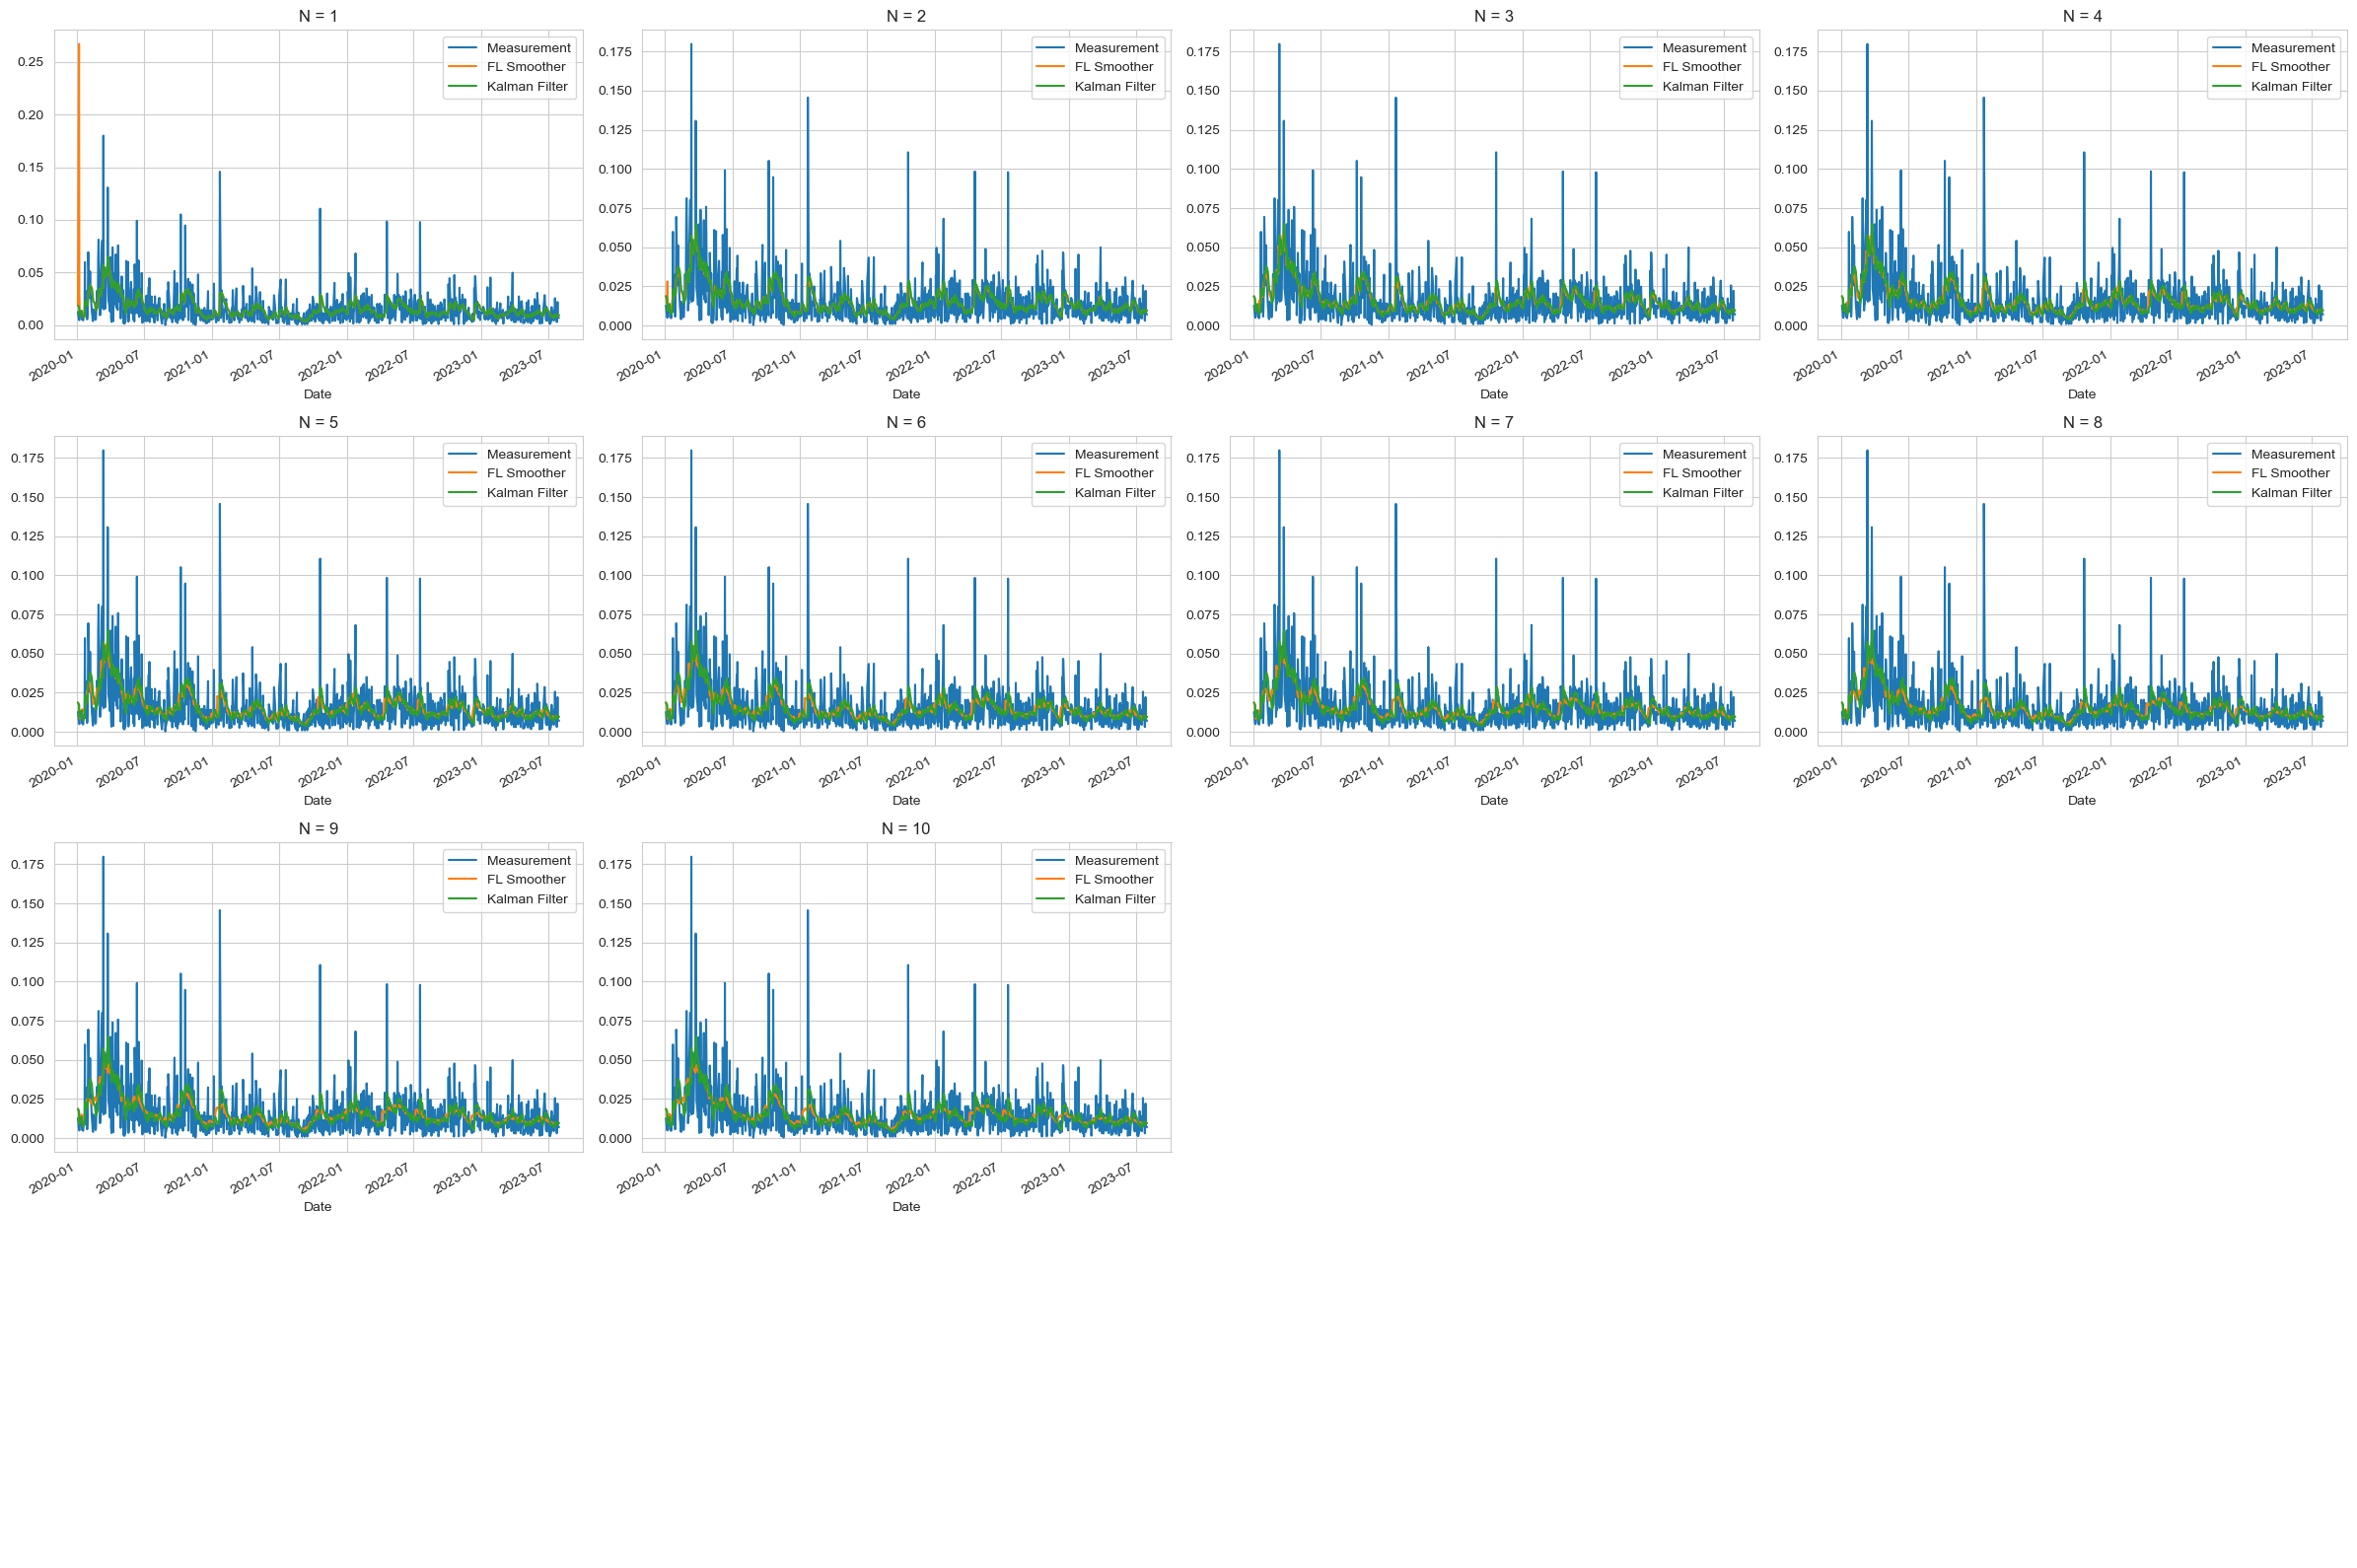

In [8]:
N = range(1, 11)
l = int(np.ceil(np.sqrt(len(N))))

plt.figure(figsize=(24, 16))
fig, axes = plt.subplots(l, l, figsize=(24, 16))

for i, j in enumerate(N):
    result = calculate_fl(becker_parkinson, N=j)
    result.plot(ax=axes[i//l, i%l], title="N = {}".format(j))

for k in range(1 + i, l ** 2):
    axes[k//l, k%l].set_axis_off()

plt.tight_layout()
plt.show()